In [1]:
from dotenv import load_dotenv
import sys

sys.path.append("../../common")
load_dotenv()

True

In [2]:
import os
from langsmith_tracker import set_tracking

# 인스턴스를 생성할 때 필요한 매개변수를 전달합니다.
set_tracking(project_name="17.LangGraph")

Langsmith 추적이 활성화되었습니다. [프로젝트명: 17.LangGraph]


### 사람에게 물어보는 노드

특정 노드에 도달하면 사람에게 물어보는 노드를 추가하는 방법입니다.  
  
Human이라는 노드를 추가합니다.

#### 사람에게 의견을 묻는 노드를 설정합니다.

In [3]:
from typing import Annotated
from typing_extensions import TypedDict
from tools_tavily import TavilySearch
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

##### 1. 중간에 사람에게 질문할지 여부(ask_human)를 묻는 상태를 추가합니다.

In [4]:
class State(TypedDict):
    # 메시지 목록
    messages: Annotated[(list, add_messages)]
    # 사람에게 질문할지 여부
    ask_human: bool

##### 2. 사람(ask_human: True)에 대한 요청시 사용되는 스키마를 정의합니다.

In [5]:
from pydantic import BaseModel


class HumnaRequest(BaseModel):
    """Forward the conversation to an expert. Use when you can't assist directly or the user needs assistance that exceeds your authority.
    To use this function, pass the user's 'request' so that an expert can provide appropriate guidance.
    """

    request: str

##### 3. 챗봇 노드를 정의합니다.

In [29]:
from langchain_openai import ChatOpenAI

# 도구 추가
tool = TavilySearch(max_results=5)

# 도구 목록 추가(HumanRequest 도구)
tools = [tool, HumnaRequest]

# LLM 추가
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# 도구 바인딩
llm_with_tools = llm.bind_tools(tools)


# 챗본 노드 구성
def chatbot(state: State):
    # LLM 도구 호출을 통한 응답 생성
    response = llm_with_tools.invoke(state["messages"])

    # 사람에게 질문할지 여부 초기화
    ask_human = False

    # 도구 호출이 있고 이름이 'HumanRequest'인 경우
    if response.tool_calls and response.tool_calls[0]["name"] == HumnaRequest.__name__:
        ask_human = True

    # 메시지와 ask_human 상태 변환
    return {"messages": [response], "ask_human": ask_human}

##### 4. 그래프를 구성하기 위하여, 그래프 빌더를 생성하고 chatbot과 tools 노드를 그래프에 추가합니다.

In [30]:
# 상태 그래프 초기화
graph_builder = StateGraph(State)

# 챗봇 노드 추가
graph_builder.add_node("chatbot", chatbot)

# 도구 노드 추가
graph_builder.add_node("tools", ToolNode(tools=[tool]))

##### 5. Human 노드를 설정합니다. 

1. 기본 목적
    - 대화 흐름 중에 사람의 입력이 필요한 시점을 처리하는 노드입니다.
    - 실제 사람이 응답할 때까지 대기하거나, 응답이 없을 경우의 처리를 담당합니다.

2. 주요 기능
    - 사람의 응답이 없을 경우 "No response from human"이라는 메시지를 생성합니다.
    - `ask_human` 플래그를 False로 설정하여 더 이상 사람에게 물어보지 않도록 합니다.


In [31]:
from langchain_core.messages import AIMessage, ToolMessage


# 응답 메시지 생성(ToolMessage 생성을 위한 함수)
def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]["id"],
    )


# 인간 노드 처리
def human_node(state: State):
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage):
        # 사람으로부터 응답이 없는 경우
        new_messages.append(
            create_response("No response from human.", state["messages"][-1])
        )
    return {
        # 새 메시지 추가
        "messages": new_messages,
        # 플래그 해제
        "ask_human": False,
    }


# 그래프에 인간 노드 추가
graph_builder.add_node("human", human_node)

##### 6. 조건부 논리를 정의합니다.

**흐름**  
  
- `select_next_node` 함수를 통해 다음 실행할 노드를 결정합니다:
    - `ask_human`이 True면 human 노드로
    - 그 외의 경우 tools 노드나 종료 상태로 이동
- Human 노드에서는 사람의 응답이 없을 경우 "No response from human" 메시지를 생성하고 `ask_human` 플래그를 False로 설정합니다.

In [32]:
from langgraph.graph import END


# 다음 노드 선택
def select_next_node(state: State):
    # 인간에게 질문 여부 확인
    if state["ask_human"]:
        return "human"
    # 이전과 동일한 경로 설정
    return tools_condition(state)


# 조건부 엣지 추가
graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "tools": "tools", END: END},
)

##### 7. 엣지를 연결하고 그래프를 컴파일합니다.

In [33]:
# 엣지 추가: 'tools'에서 'chatbot'으로
graph_builder.add_edge("tools", "chatbot")

# 엣지 추가: 'human'에서 'chatbot'으로
graph_builder.add_edge("human", "chatbot")

# 엣지 추가: START에서 'chatbot'으로
graph_builder.add_edge(START, "chatbot")

# 메모리 저장소 초기화
memory = MemorySaver()

# 그래프 컴파일: 메모리 체크포인터 사용
graph = graph_builder.compile(
    checkpointer=memory,
    # 'human' 이전에 인터럽트 설정
    interrupt_before=["human"],
)

##### 8. 그래프를 시각화 합니다.

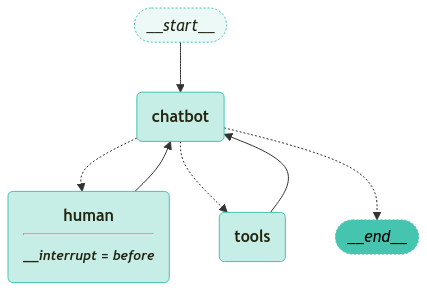

In [34]:
from graphs import visualize_graph

visualize_graph(graph)

chatbot 노드는 다음과 같은 동작을 합니다.  
  
- 챗봇은 인간에게 도움을 요청할 수 있으며 (chatbot->select->human)
- 검색 엔진 도구를 호출하거나 (chatbot->select->action)
- 직접 응답할 수 있습니다 (chatbot->select->end).

일단 행동이나 요청이 이루어지면, 그래프는 chatbot 노드로 다시 전환되어 작업을 계속합니다.

##### 9. 실행합니다.

In [35]:
# user_input = "이 AI 에이전트를 구축하기 위해 전문가의 도움이 필요합니다. 검색해서 답변하세요"  # (Human 이 아닌 웹검색을 수행하는 경우)
user_input = "이 AI 에이전트를 구축하기 위해 전문가의 도움이 필요합니다. 도움을 요청할 수 있나요?"

# config 설정
config = {"configurable": {"thread_id": "2"}}

# 스트림 또는 호출의 두 번째 위치 인수로서의 구성
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

이 AI 에이전트를 구축하기 위해 전문가의 도움이 필요합니다. 도움을 요청할 수 있나요?
================================== Ai Message ==================================
Tool Calls:
  HumnaRequest (call_GC5Hyl1HjCFn7CZslH74nzIV)
 Call ID: call_GC5Hyl1HjCFn7CZslH74nzIV
  Args:
    request: AI 에이전트를 구축하는 데 필요한 전문가의 도움을 요청합니다. 구체적으로 어떤 기술 스택과 방법론이 필요한지, 그리고 프로젝트를 시작하기 위한 단계에 대한 조언이 필요합니다.


In [36]:
# 그래프 상태 스냅샷 생성
snapshot = graph.get_state(config)

# 다음 스냅샷 상태 접근
snapshot.next

('human',)

##### 10. 챗봇 요청에 대한 응답을 수행합니다.
1. 응답을 포함한 `ToolMessage`를 생성합니다. 이 내용은 다시 `chatbot` 노드로 전달됩니다.
2. `update_state` 메서드를 사용하여 그래프 상태를 업데이트합니다.

In [37]:
# AI 메시지 추출
ai_message = snapshot.values["messages"][-1]

# 인간 응답 생성
human_response = (
    "전문가들이 도와드리겠습니다! 에이전트 구축을 위해 LangGraph를 확인해 보시기를 적극 추천드립니다. "
    "단순한 자율 에이전트보다 훨씬 더 안정적이고 확장성이 뛰어납니다. "
    "https://wikidocs.net/233785 에서 더 많은 정보를 확인할 수 있습니다."
)

# 도구 메시지 생성
tool_message = create_response(human_response, ai_message)

# 그래프 상태 업데이트
graph.update_state(config, {"messages": [tool_message]})

{'configurable': {'thread_id': '2',
  'checkpoint_ns': '',
  'checkpoint_id': '1efb9163-b890-6c6e-8002-f8a961dd6056'}}

##### 11. 상태를 확인하여 응답에 추가되었는지 확인합니다.

In [38]:
# 그래프 상태에서 메시지 값 가져오
graph.get_state(config).values["messages"]

[HumanMessage(content='이 AI 에이전트를 구축하기 위해 전문가의 도움이 필요합니다. 도움을 요청할 수 있나요?', additional_kwargs={}, response_metadata={}, id='b0bb1493-8bcd-4db2-80e6-f8e8d4c83ab4'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_GC5Hyl1HjCFn7CZslH74nzIV', 'function': {'arguments': '{"request":"AI 에이전트를 구축하는 데 필요한 전문가의 도움을 요청합니다. 구체적으로 어떤 기술 스택과 방법론이 필요한지, 그리고 프로젝트를 시작하기 위한 단계에 대한 조언이 필요합니다."}', 'name': 'HumnaRequest'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 59, 'prompt_tokens': 172, 'total_tokens': 231, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_6fc10e10eb', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-f5bcd02a-a6cb-49bc-9cf0-cf06cbdbec23-0', tool_calls=[{'name': 'HumnaRequest', 'args': {

##### 12. 입력값으로 None 을 추가하여 그래프를 제출(resume)합니다.

In [39]:
# 그래프에서 이벤트 스트림 생성
events = graph.stream(None, config, stream_mode="values")

# 각 이벤트에 대한 처리
for event in events:
    # 메시지가 있는 경우 마지막 메시지 출력
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================= Tool Message =================================

전문가들이 도와드리겠습니다! 에이전트 구축을 위해 LangGraph를 확인해 보시기를 적극 추천드립니다. 단순한 자율 에이전트보다 훨씬 더 안정적이고 확장성이 뛰어납니다. https://wikidocs.net/233785 에서 더 많은 정보를 확인할 수 있습니다.
================================= Tool Message =================================

전문가들이 도와드리겠습니다! 에이전트 구축을 위해 LangGraph를 확인해 보시기를 적극 추천드립니다. 단순한 자율 에이전트보다 훨씬 더 안정적이고 확장성이 뛰어납니다. https://wikidocs.net/233785 에서 더 많은 정보를 확인할 수 있습니다.
================================== Ai Message ==================================

AI 에이전트를 구축하기 위해 전문가의 도움을 요청했습니다. 추천된 자료는 LangGraph로, 이는 단순한 자율 에이전트보다 훨씬 더 안정적이고 확장성이 뛰어납니다. 더 많은 정보는 [여기](https://wikidocs.net/233785)에서 확인하실 수 있습니다. 도움이 필요하시면 언제든지 말씀해 주세요!


최종 결과를 확인합니다.

In [40]:
# 최종 상태 확인
state = graph.get_state(config)

# 단계별 메시지 출력
for message in state.values["messages"]:
    message.pretty_print()

================================ Human Message =================================

이 AI 에이전트를 구축하기 위해 전문가의 도움이 필요합니다. 도움을 요청할 수 있나요?
================================== Ai Message ==================================
Tool Calls:
  HumnaRequest (call_GC5Hyl1HjCFn7CZslH74nzIV)
 Call ID: call_GC5Hyl1HjCFn7CZslH74nzIV
  Args:
    request: AI 에이전트를 구축하는 데 필요한 전문가의 도움을 요청합니다. 구체적으로 어떤 기술 스택과 방법론이 필요한지, 그리고 프로젝트를 시작하기 위한 단계에 대한 조언이 필요합니다.
================================= Tool Message =================================

전문가들이 도와드리겠습니다! 에이전트 구축을 위해 LangGraph를 확인해 보시기를 적극 추천드립니다. 단순한 자율 에이전트보다 훨씬 더 안정적이고 확장성이 뛰어납니다. https://wikidocs.net/233785 에서 더 많은 정보를 확인할 수 있습니다.
================================== Ai Message ==================================

AI 에이전트를 구축하기 위해 전문가의 도움을 요청했습니다. 추천된 자료는 LangGraph로, 이는 단순한 자율 에이전트보다 훨씬 더 안정적이고 확장성이 뛰어납니다. 더 많은 정보는 [여기](https://wikidocs.net/233785)에서 확인하실 수 있습니다. 도움이 필요하시면 언제든지 말씀해 주세요!
